<a href="https://colab.research.google.com/github/BrianAriel/AndroidTP/blob/master/HPC/Cuaderno_1_Miercoles_Grupo1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Introducción**
---

La diferencia entre dos imagenes consiste en un proceso que toma como entrada dos ilustraciones cualesquiera y deja como resultado una sola imagen con los pixeles de la primera imagen que no tienen el mismo color que los pixeles, en exactamente la misma posicion, de la segunda imagen. Para que el ejercicio pueda ejecutarse sin problemas es condicion necesaria que ambas imagenes input sean de las mismas dimensiones.

Es una operacion matematica muy sencilla donde simplemente se hace una resta de los valores RGB de la imagen. En caso de que ambas imagenes tengan un pixel en el mismo lugar del mismo color, esa diferencia generara un resultado cero, o lo que es equivalente, el color negro.

# **2 Armado del Ambiente**
---

Tomamos dos imagenes y las añadimos al contexto de ejecución de Colab y, además, instalamos el modulo CUDA en nuestro cuaderno para que pueda ser utilizado en el desarrollo GPU.

---


In [ ]:
#@title # 2.1 Parámetros de ejecución secuencial
#@markdown ---
#@markdown ### Inserte las URL de las dos imagens a diferenciar
url_primera_imagen =  "https://cdn.pixabay.com/photo/2016/10/17/06/33/puzzle-1747056_960_720.png" #@param {type:"string"}
url_segunda_imagen =  "https://cdn.pixabay.com/photo/2016/10/17/06/32/puzzle-1747054_960_720.png" #@param {type:"string"}
#@markdown ---

#Leemos las imagenes desde las URL introducidas
!wget {url_primera_imagen} -O imagen_uno.jpeg
!wget {url_segunda_imagen} -O imagen_dos.jpeg

#Seteamos la lista para guardar los tiempos de ejecucion concurrentes
tiempos_de_ejecucion_concurrente = []

--2021-06-24 00:37:30--  https://cdn.pixabay.com/photo/2016/10/17/06/33/puzzle-1747056_960_720.png
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146293 (143K) [image/png]
Saving to: ‘imagen_uno.jpeg’

imagen_uno.jpeg     100%[===================>] 142.86K  --.-KB/s    in 0.02s   

2021-06-24 00:37:31 (8.47 MB/s) - ‘imagen_uno.jpeg’ saved [146293/146293]

--2021-06-24 00:37:31--  https://cdn.pixabay.com/photo/2016/10/17/06/32/puzzle-1747054_960_720.png
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169084 (165K) [image/png]
Saving to: ‘imagen_dos.jpeg’

imagen_dos.jpeg     100%[===================>] 165.12K  

In [ ]:
#@title # 2.2 Instalación CUDA
!pip install pycuda

     |████████████████████████████████| 1.7MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627913 sha256=c93acfa3a731ed709c190bbf96ed44c98e2fb007ae6faea69ef5e947a3686eb6
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=41b2644180896b955f715b316f6439ec2638b34f1ca28c5a57a626a8b34e78ed
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


# **3 Desarrollo CPU**
---

Realizamos la ejecución del algoritmo secuencial donde primero comprobamos que se tratan de dos imagenes y luego chequeamos las dimensiones de ambas. En caso de ser iguales, procedemos a recorrer ambas pixel por pixel, restandolas y obteniendo una imagen final.

---

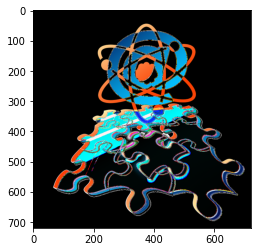

In [ ]:
#@title # 3.1 Implementación secuencial

from datetime import datetime
tiempo_ejecucion_secuencial = datetime.now()

from PIL import Image
import imghdr
import numpy
import matplotlib.pyplot as plt

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre_uno = 'imagen_uno.jpeg'
img_nombre_dos = 'imagen_dos.jpeg'

formatos_permitidos = ("jpeg","png")

try:
  if (not imghdr.what(img_nombre_uno) in formatos_permitidos or
      not imghdr.what(img_nombre_dos) in formatos_permitidos):
    raise Exception("Las imagenes no corresponden al formato JPG o PNG")
except Exception as e:
  print("Error:", e.args)
else:
  imagen_uno = Image.open(img_nombre_uno)
  imagen_dos = Image.open(img_nombre_dos)

  imagen_uno_alto, imagen_uno_ancho = imagen_uno.size
  imagen_dos_alto, imagen_dos_ancho = imagen_dos.size
  try:
      if (imagen_uno_alto != imagen_dos_alto or
          imagen_uno_ancho != imagen_dos_ancho):
        raise Exception("Las imagenes no tienen las mismas dimensiones.")
  except Exception as e:
    print("Error:", e.args)
  else:
    imagen_uno_array = numpy.asarray(imagen_uno)
    imagen_dos_array = numpy.asarray(imagen_dos)
    imagen_resultado = numpy.empty_like(imagen_uno_array)

    for i in range(0,imagen_uno_alto):
      for j in range(0,imagen_uno_ancho):
        imagen_resultado[i][j] = imagen_uno_array[i][j] - imagen_dos_array[i][j]
    
    tiempo_ejecucion_secuencial = datetime.now() - tiempo_ejecucion_secuencial

    plt.figure()
    imgplot = plt.imshow(imagen_resultado)

# **4 Desarrollo GPU**

---
La siguiente porcion de codigo corresponde a la ejecucion asistida por GPU. Realizamos los mismos chequeos que en el desarrollo CPU, pero la logica de sustraccion sera aplicada mediante CUDA. Esta porcion de codigo es parametrizable lo que permite experimentar con la cantidad de hilos planificados y qué imagen se quiere procesar y cuánto, pero por defecto se setea en 8 hilos GPU y ambas ilustraciones por completo

---

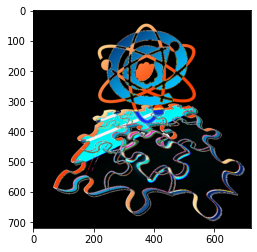

In [ ]:
#@title # 4.1 Implementación concurrente
#@markdown ---
cantidad_hilos_GPU =  32#@param {type:"integer",min:1,max:32}
procesamiento_imagenes = "ambas_completas" #@param ["mitad_inicial_origen_uno", "mitad_final_origen_dos", "ambas_completas"]
#@markdown ---

from datetime import datetime
tiempo_ejecucion_concurrente = datetime.now()

from PIL import Image
import imghdr
import numpy
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre_uno = 'imagen_uno.jpeg'
img_nombre_dos = 'imagen_dos.jpeg'

formatos_permitidos = ("jpeg","png")

try:
  if (not imghdr.what(img_nombre_uno) in formatos_permitidos or
      not imghdr.what(img_nombre_dos) in formatos_permitidos):
    raise Exception("Las imagenes no corresponden al formato JPG o PNG")
except Exception as e:
  print("Error:", e.args)
else:
  imagen_uno = Image.open(img_nombre_uno)
  imagen_dos = Image.open(img_nombre_dos)

  imagen_uno_alto, imagen_uno_ancho = imagen_uno.size
  imagen_dos_alto, imagen_dos_ancho = imagen_dos.size
  try:
      if (imagen_uno_alto != imagen_dos_alto or
          imagen_uno_ancho != imagen_dos_ancho):
        raise Exception("Las imagenes no tienen las mismas dimensiones.")
  except Exception as e:
    print("Error:", e.args)
  else:
    #Primero convertimos las imagenes a array
    imagen_uno_cpu = numpy.asarray(imagen_uno)
    imagen_dos_cpu = numpy.asarray(imagen_dos)
    imagen_resultado_cpu = numpy.empty_like(imagen_uno_cpu)

    #Segundo reservamos los 3 vectores en GPU
    imagen_uno_gpu = cuda.mem_alloc(imagen_uno_cpu.nbytes)
    imagen_dos_gpu = cuda.mem_alloc(imagen_dos_cpu.nbytes)
    imagen_resultado_gpu = cuda.mem_alloc(imagen_resultado_cpu.nbytes)

    #Tercero copiamos la memoria al GPU
    cuda.memcpy_htod(imagen_uno_gpu, imagen_uno_cpu)
    cuda.memcpy_htod(imagen_dos_gpu, imagen_dos_cpu)
    cuda.memcpy_htod(imagen_resultado_gpu, imagen_resultado_cpu)

    #Cuarto definimos la funcion kernel a ejecutar en GPU
    module = SourceModule("""
    __global__ void gpu_diferencia_imagenes(int alto_inicial, int ancho, int alto, 
    unsigned char *imagen_uno, unsigned char *imagen_dos, 
    unsigned char *imagen_resultado)
    {
      //Calculo las coordenadas en dos dimensiones
      int idx = threadIdx.x + blockIdx.x * blockDim.x;
      int idy = threadIdx.y + blockIdx.y * blockDim.y;

      if(idx < ancho && idy < alto && idy > alto_inicial)
      {
        imagen_resultado[(idx + (idy * ancho))*3+0] = 
        imagen_uno[(idx + (idy * ancho))*3+0] - imagen_dos[(idx + (idy * ancho))*3+0];
        
        imagen_resultado[(idx + (idy * ancho))*3+1] = 
        imagen_uno[(idx + (idy * ancho))*3+1] - imagen_dos[(idx + (idy * ancho))*3+1];
        
        imagen_resultado[(idx + (idy * ancho))*3+2] = 
        imagen_uno[(idx + (idy * ancho))*3+2] - imagen_dos[(idx + (idy * ancho))*3+2];
      }
    }
    """)

    #Quinto generamos la funcion kernel
    kernel = module.get_function("gpu_diferencia_imagenes")

    dim_hilo_x = cantidad_hilos_GPU
    dim_bloque_x = numpy.int((cantidad_hilos_GPU + imagen_uno_ancho - 1) / dim_hilo_x)

    dim_hilo_y = cantidad_hilos_GPU
    dim_bloque_y = numpy.int((cantidad_hilos_GPU + imagen_uno_alto - 1)/ dim_hilo_y)

    if procesamiento_imagenes == "mitad_inicial_origen_uno":
      imagen_uno_alto = imagen_uno_alto / 2
      alto_inicial = 0
    elif procesamiento_imagenes == "mitad_final_origen_dos":
      alto_inicial = imagen_uno_alto / 2
    else:
      alto_inicial = 0
    
    kernel(numpy.int32(alto_inicial), numpy.int32(imagen_uno_ancho), 
           numpy.int32(imagen_uno_alto), imagen_uno_gpu, imagen_dos_gpu, 
           imagen_resultado_gpu,
           block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))
    
    cuda.Context.synchronize()

    #Sexto copiamos el resultado desde la memoria de GPU
    cuda.memcpy_dtoh(imagen_resultado_cpu,imagen_resultado_gpu)

    #Septimo conseguimos el tiempo de ejecucion
    tiempo_ejecucion_concurrente = datetime.now() - tiempo_ejecucion_concurrente

    #Octavo mostramos los resultados
    tiempos_de_ejecucion_concurrente.append([cantidad_hilos_GPU,tiempo_ejecucion_concurrente])

    plt.figure()
    imgplot=plt.imshow(imagen_resultado_cpu)


# **5 Métricas**

---

En esta sección vamos a analizar, mediante gráficos y resultados, las diferencias entre la implementación secuencial y concurrente. Ademas vamos a incluir gráficos comparando los tiempos de respuesta con la cantidad de nucleos GPU implementados

Tiempo de ejecucion secuencial en milisegundos:  1119.127
Ahora una comparativa de los tiempos de ejecucion concurrentes y la cantidad de hilos asociados
Tiempo de ejecucion concurrente en milisegundos 1415.385 | Cantidad de hilos 8
Tiempo de ejecucion concurrente en milisegundos 20.489 | Cantidad de hilos 8
Tiempo de ejecucion concurrente en milisegundos 19.211 | Cantidad de hilos 8
Tiempo de ejecucion concurrente en milisegundos 19.153 | Cantidad de hilos 8
Tiempo de ejecucion concurrente en milisegundos 19.097 | Cantidad de hilos 32
Tiempo de ejecucion concurrente en milisegundos 21.171 | Cantidad de hilos 32
GRÁFICO ASOCIADO


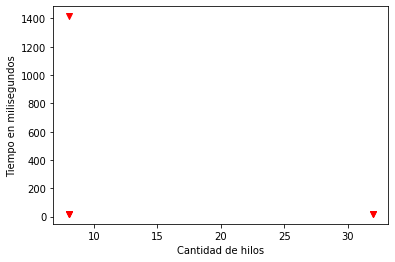

In [ ]:
#@title 5.1 Análisis con código

plt.xlabel("Cantidad de hilos")
plt.ylabel("Tiempo en milisegundos")

print("Tiempo de ejecucion secuencial en milisegundos: ", tiempo_en_ms(tiempo_ejecucion_secuencial))

print("Ahora una comparativa de los tiempos de ejecucion concurrentes y la cantidad de hilos asociados")
for n in tiempos_de_ejecucion_concurrente:
  print("Tiempo de ejecucion concurrente en milisegundos", tiempo_en_ms(n[1]) ,"| Cantidad de hilos", n[0])
  plt.scatter(n[0],tiempo_en_ms(n[1]),marker='v', color='r')
print("GRÁFICO ASOCIADO")
plt.show()




# **6 Conclusiones**

---

Como pudimos observar de las métricas obtenidas el tiempo de respuesta del desarrollo CPU es muy grande en comparación con los tiempos de la implementacion concurrente. Si hablamos de números, podríamos decir que es una diferencia de al menos 1000 ms, o el equivalente, 1 segundo.

***ACLARACIÓN: las siguientes conclusiones son producto de varias ejecuciones de la implementacion CUDA, variando la cantidad de hilos a planificar***

Por otro lado si ejecutamos varias veces el desarrollo GPU variando la cantidad de hilos a planificar, podemos ver diferencias entre los tiempos de ejecucion. No son demasiado amplias ya que varian entre +- 2 ms, pero podemos ver que siendo la medida menor al default propuesto por el equipo (bloques de 8x8) los tiempos de respuesta empiezan a subir.

En el posterior informe se va a detallar qué ocurre con cada experimento en particular, pero las conclusiones son claras y simples:
Mientras que ambas implementaciones cumplen el objetivo, el desarrollo GPU tiene tiempos de respuesta superiores. Si se escalara la imagen ejemplo de 720x720 a algo del estilo 3200x3200 entonces las diferencias temporales serian bastante más amplias

# **7 Biblografía**
---
[1] W.Valiente. SOA_HPC [Online]. Available: https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%201%20-%20Vectores%20-%20GPU.ipynb
---
[2] W.Valiente. SOA_HPC [Online]. Available: https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb
---
[3] Python Documentation [Online]. Available: https://docs.python.org/3/library/imghdr.html
---
[4] Matplotlib Documentation [Online]. Available: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
---